In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter

from vision.tools.camera import find_gl_by_percentile, plot_img, plot_two_img
from vision.depth.slicer.slicer import get_grad, get_search_limits, find_best_routh, slice_frame



In [2]:
def plot_img_and_line(img, x1, y1, x2=None, y2=None):
    f, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img)
    ax.plot(x1, y1, 'b')
    if x2 is not None and y2 is not None:
        ax.plot(x2, y2, 'r')

In [3]:
f_id = 270
fp = f"/home/yotam/FruitSpec/Sandbox/slicer_test/caracara_R2_3011/sliced3/depth/depth_frame_{f_id}.jpg"
depth = cv2.imread(fp)
depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
fp = f"/home/yotam/FruitSpec/Sandbox/slicer_test/caracara_R2_3011/sliced3/frames/frame_{f_id}.jpg"
frame = cv2.imread(fp)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

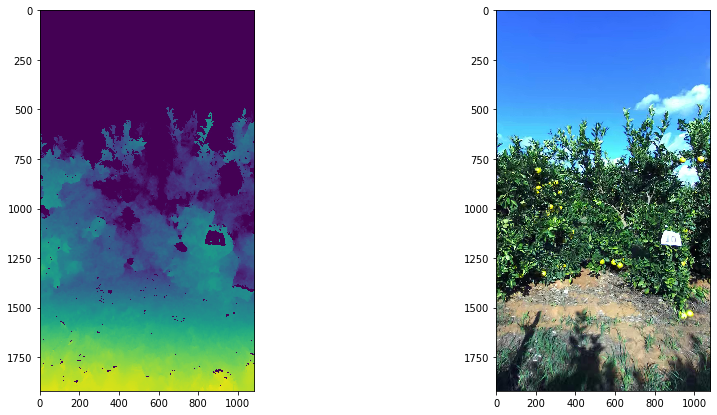

In [4]:
plot_two_img(depth, frame)

In [31]:
pos_grad, neg_grad = get_grad(depth,  k_size=7)
first, last = get_search_limits(neg_grad)

croped_depth = depth[first:last, :].copy()

nearest = np.max(croped_depth)
mean_vec = np.mean(croped_depth, axis=0)

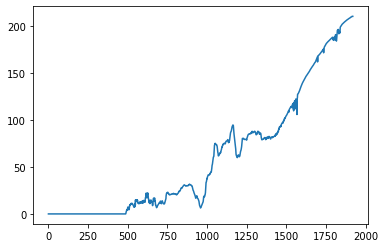

In [19]:
v = np.mean(depth[:,600:800], axis=1)
plt.plot(v)

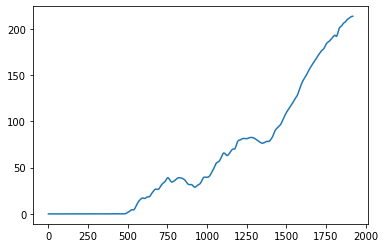

In [13]:
v1 = gaussian_filter1d(v, 7)
plt.plot(v1)

In [28]:
w = depth.shape[1]
slices = np.arange(0, w, w // 5).astype(np.int16)

In [32]:
print(slices)
np.append(slices, w)

[  0 216 432 648 864]


array([   0,  216,  432,  648,  864, 1080])

In [44]:
s = 0
e = w
vecs = []
for i in slices[1:]:
    v = np.mean(depth[:,s:i], axis=1)
    v = gaussian_filter1d(v, 11)
    vecs.append(v)
    s = i
d = []
v_l = vecs[0]
for v in vecs[1:]:
    d.append(np.abs(v-v_l))
    v_l = v.copy()

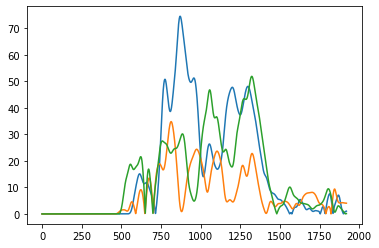

In [45]:
d = np.array(d)
plt.plot(d.T)

No handles with labels found to put in legend.


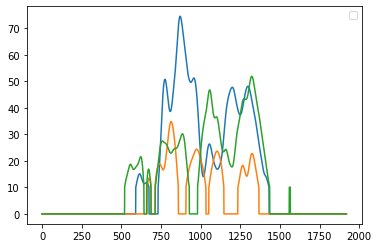

In [63]:
d_t = d.copy()
d_t[d < 10] = 0
plt.plot(d_t.T)

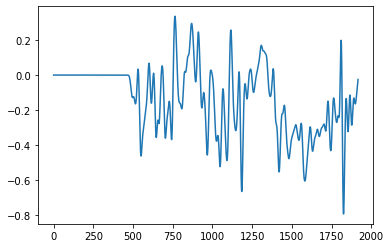

In [15]:
k = [-1, -1, 0, 1, 1]
s1 = np.convolve(v1, k, mode='same') / 5
plt.plot(s1[:-2])

In [27]:
pos_grad, neg_grad = get_grad(depth, direction='y', k_size=7)
#first, last = get_search_limits(neg_grad)
energy = np.abs(np.sum(pos_grad + np.abs(neg_grad), axis=1))

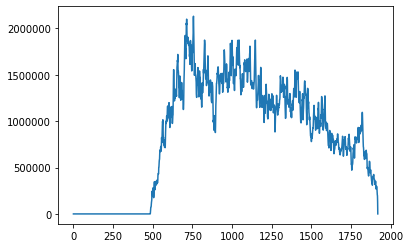

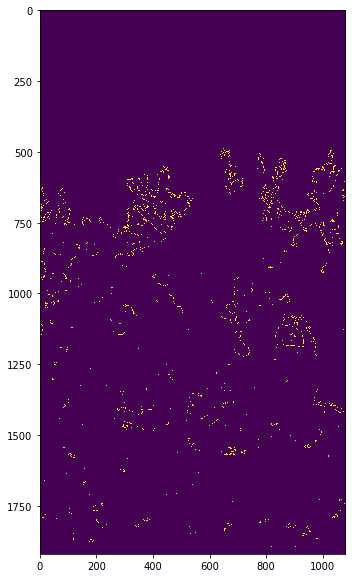

In [47]:
edges = cv2.Canny(depth,100,200)
plot_img(edges)

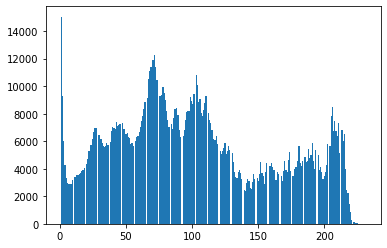

In [43]:
_ = plt.hist(depth[depth>0].flatten(),255)

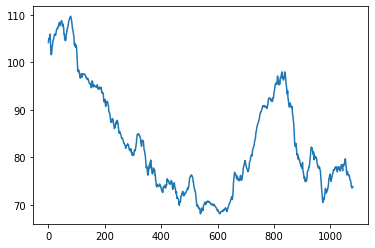

In [8]:
plt.plot(mean_vec)

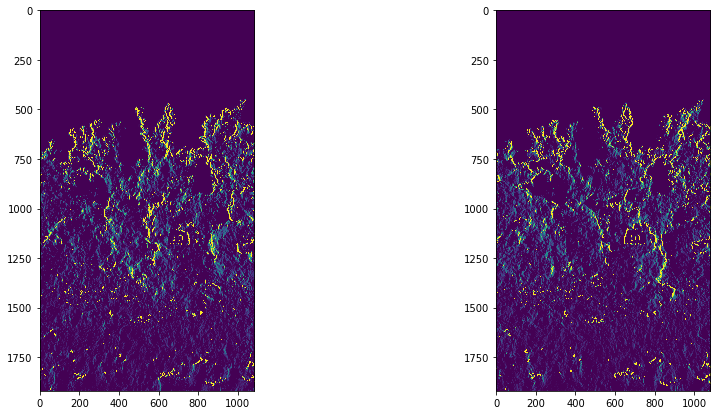

In [5]:
p, n = get_grad(depth, k_size=7)
plot_two_img(np.abs(p), np.abs(n))

In [6]:
gaps = slice_frame(depth, grad_kernel=7, depth_thrs=70)
gaps.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

delta: 90.14696132596686
n_me: 1600811.0
p_me: 1458049.0


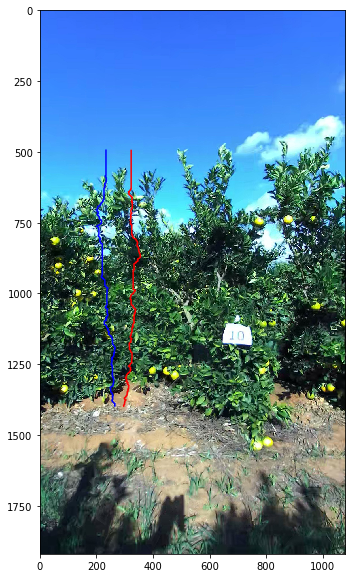

In [28]:
i = 9
plot_img_and_line(frame, gaps[i]['n_xs'], gaps[i]['n_ys'], gaps[i]['p_xs'], gaps[i]['p_ys'])
print(f"delta: {gaps[i]['delta']}")
print(f"n_me: {gaps[i]['n_mes']}")
print(f"p_me: {gaps[i]['p_mes']}")

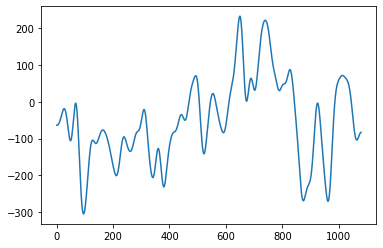

In [40]:
g = p+n
m =np.mean(g, axis =0)
mg = gaussian_filter1d(m, 10) 
plt.plot(mg)

In [41]:
z1 = mg < 10
z2 = mg > -10
z = z1 & z2
np.sum(z)

41

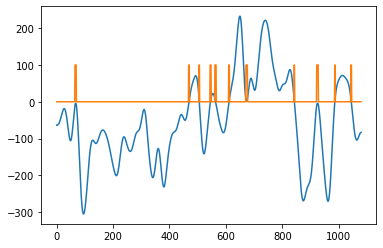

In [42]:
plt.plot(mg)
plt.plot(z*100)

In [11]:
n_g = median_filter(np.abs(neg_grad), 5)
p_g = median_filter(np.abs(pos_grad), 5)

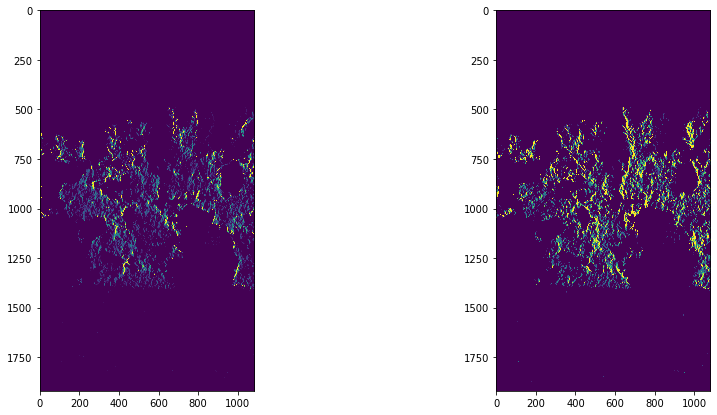

In [12]:
plot_two_img(n_g, p_g)

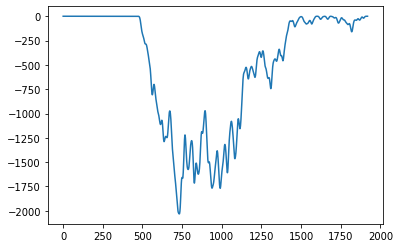

In [27]:
s1 = gaussian_filter1d(s, 5)
plt.plot(s1)

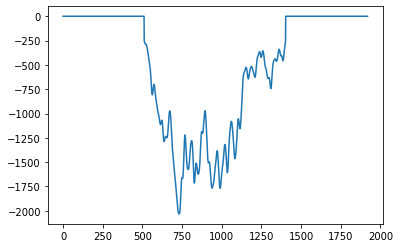

In [31]:
s1[s1>-250] = 0
plt.plot(s1)

In [33]:
def last_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

last_nonzero(s1, axis=0, invalid_val=-1)

array(1402)

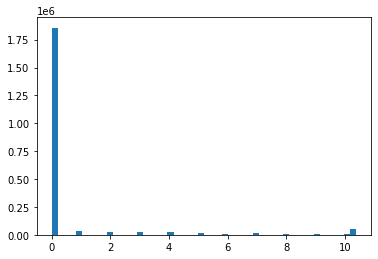

In [12]:
_ = plt.hist(p_g.flatten(), 50)

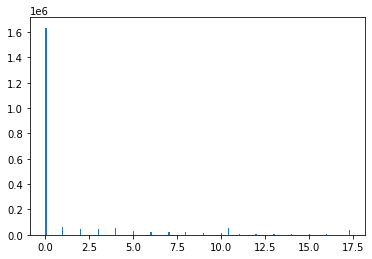

In [235]:
_ = plt.hist(abs_grad_x.flatten(), 255)

In [236]:
grad_x_view = (abs_grad_x - abs_grad_x.min()) / (abs_grad_x.max() - abs_grad_x.min()) * 255

<BarContainer object of 255 artists>

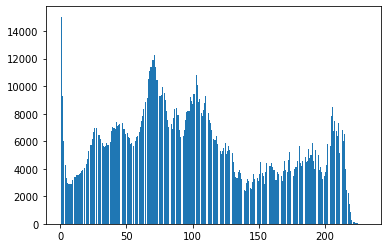

In [11]:
h, b = np.histogram(im[im > 0].flatten(), 255)
plt.bar(b[:-1], h)

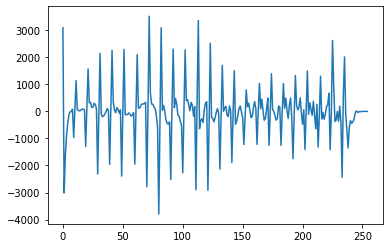

In [10]:
#w = 10
#k = [1, 0, -1]
#h = np.convolve(h, k, mode='same') / 3
#plt.bar(b[:-1], h)
#plt.plot(h)

<BarContainer object of 255 artists>

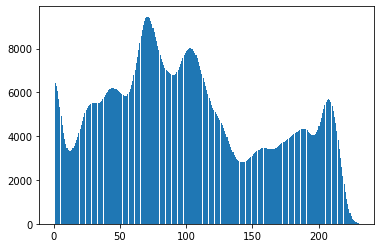

In [12]:

h1 = gaussian_filter1d(h, 5)
plt.bar(b[:-1], h1)

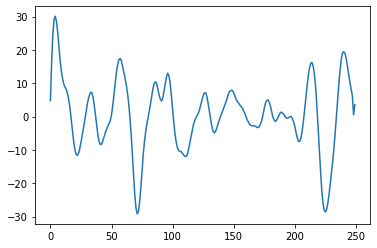

In [250]:
k = [1, 0, -1]
#h1 = np.convolve(h1, k, mode='same') / 3
#plt.bar(b[:-1], h)
plt.plot(h1[5:])

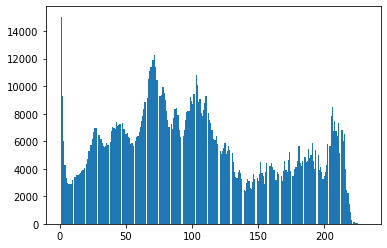

In [240]:
_ = plt.hist(im[im>0].flatten(), 255)

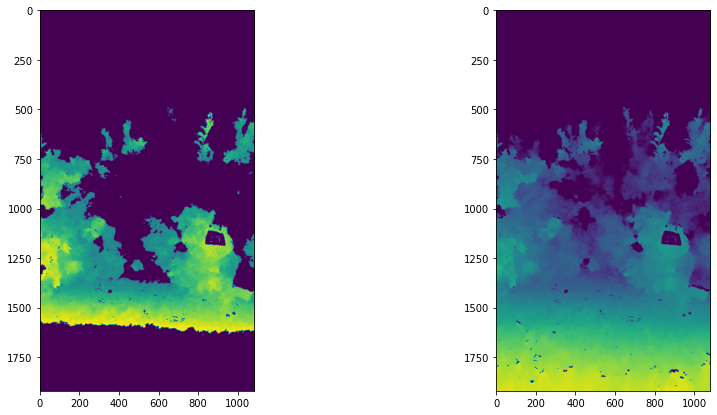

In [241]:
im_view1 = im.copy()
im_view1[im > 140] = 0
im_view1[im < 60] = 0
plot_two_img(im_view1, im)

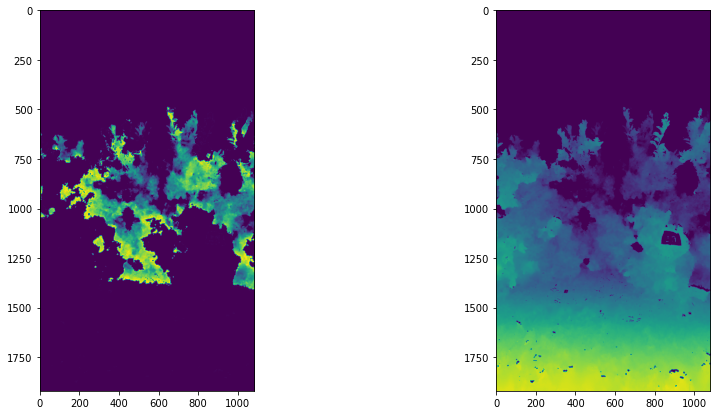

In [242]:
im_view2 = im.copy()
im_view2[im > 60] = 0
#im_view2[im < 80] = 0
plot_two_img(im_view2, im)

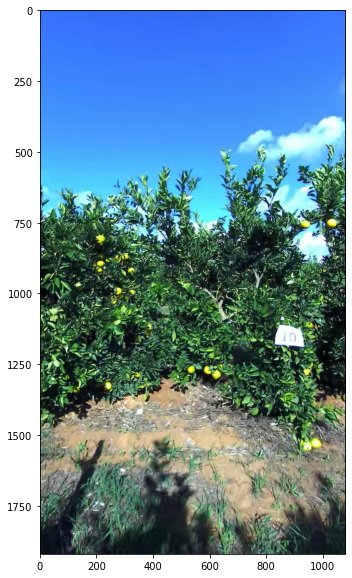

In [243]:
plot_img(frame)

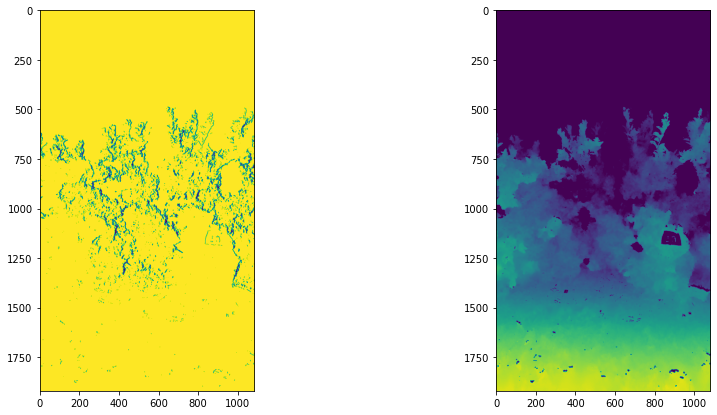

In [32]:
#grad_x_view[grad_x_view < 220]  =0
plot_two_img(n_g, im)

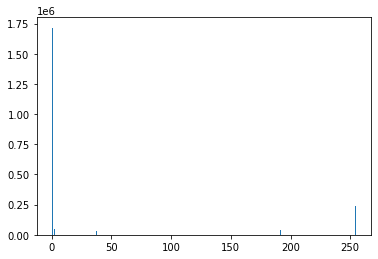

In [226]:
_ = plt.hist(grad_x_view.flatten(),255)

In [81]:
w = 15
k = np.ones(w)
m_grad = np.array([np.convolve(im[i, :], k, mode='same') / w for i in range(grad_x_view.shape[0])])

In [74]:
v = np.mean(grad_x_view, axis=0)

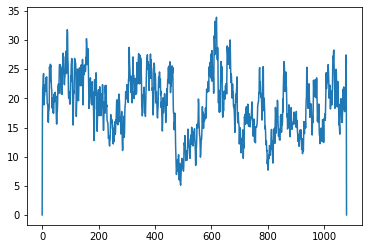

In [71]:
plt.plot(v)

TypeError: Invalid shape (1920,) for image data

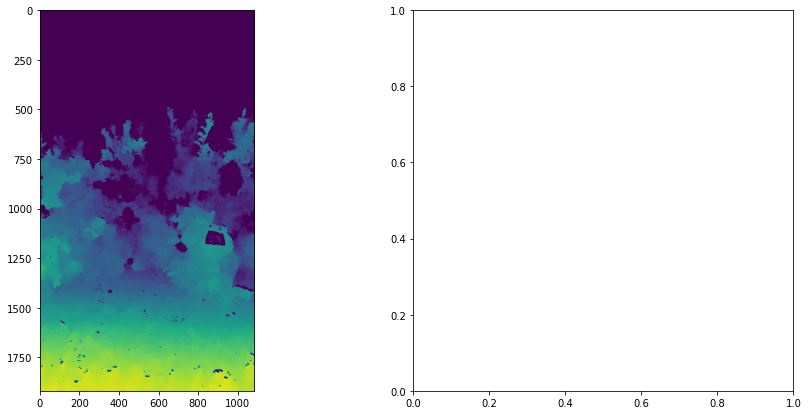

In [35]:
#plot_two_img(grad_x_view.astype(np.uint8), m_grad)
plot_two_img(im, s1)

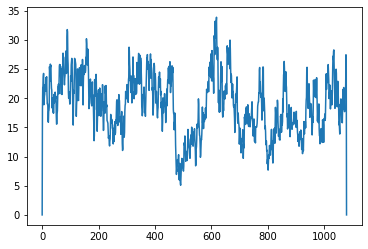

In [72]:
v1 = np.mean(m_grad, axis=0)
plt.plot(v1)

In [ ]:
c = cv2222.